In [232]:
class Table:
    def __init__(self, name, columns):
        self.name = name
        self.columns = columns
        self.rows = [] # array of dictionaries

    def add_row(self, row):
        if isinstance(row, dict):
            self.rows.append(row)
        elif isinstance(row, list):
            self.rows.append(dict(zip(self.columns, row)))
        else:
            raise TypeError("Invalid row type %s" % type(row))

    def __getitem__(self, key):
        if isinstance(key, str):
            return [row[key] for row in self.rows]
        elif isinstance(key, int):
            return self.rows[key]
        else:
            raise TypeError("Invalid key type %s" % type(key))

    def num_of_rows(self):
        return len(self.rows)

    def __str__(self):
        header = "Table(%s, %s)" % (self.name, self.columns)
        rows = "\n".join(["\t" + str(row) for row in self.rows])
        return header + "\n" + rows

    def __eq__(self, other):
        if isinstance(other, Table):
            meta_same = self.name == other.name and self.columns == other.columns
            if len(self.rows) != len(other.rows):
                return False
            rows1_sorted = sorted(self.rows, key=lambda row: tuple(row.values()))
            rows2_sorted = sorted(other.rows, key=lambda row: tuple(row.values()))

            for dict1, dict2 in zip(rows1_sorted, rows2_sorted):
                if dict1 != dict2:
                    return False
            return True
        else:
            return False

In [233]:
t1 = Table('t1', ['a', 'b', 'c'])
t1.add_row([1, 2, 3])
t1.add_row([4, 5, 6])

t2 = Table('t1', ['a', 'b', 'c'])
t2.add_row([1, 2, 3])
t2.add_row([4, 5, 6])

t3 = Table('t1', ['a', 'b', 'c'])
t3.add_row([1, 2, 3])
t3.add_row([4, 5, 7]) # <-- diff is here

print(t1['a'] == [1, 4])
print(t1[0] == {'a': 1, 'b': 2, 'c': 3})

print(t1 == t2)
print(t1 == t3)

True
True
True
False


In [273]:
class JoinStats:
    def __init__(self):
        self.left_table_sizes_per_pu = []
        self.right_table_sizes_per_pu = []
        self.total_join_checks_per_pu = []
        self.total_move_operations = 0

    def show(self):
        print(f"Total move operations - {self.total_move_operations}")

        # plot per node stats (bar plot)
        import matplotlib.pyplot as plt
        import numpy as np

        fig = plt.subplots(figsize =(12, 8))
        nodes = np.arange(len(self.left_table_sizes_per_pu)) 

        bar_width = 0.2
        bar_shift = 0.2
        bar_space = 0.1

        plt.bar(nodes, self.left_table_sizes_per_pu, label="left table sizes total", width=bar_width)
        plt.bar(nodes + bar_shift, self.right_table_sizes_per_pu, label="right table sizes total", width=bar_width)
        plt.bar(nodes + bar_shift * 2, self.total_join_checks_per_pu, label="total join checks", width=bar_width)

        plt.xticks(nodes + bar_width + bar_space, nodes)  # Adjust x-axis tick positions
        plt.title("Spool stats per PU")

        plt.legend()


In [274]:
class PU:
    def __init__(self, pu_id):
        self.hosted_tables = []
        self.pu_id = pu_id

    def add_table(self, table):
        if table.name not in [t.name for t in self.hosted_tables]:
            self.hosted_tables.append(table)
        else:
            raise ValueError("Table %s already exists" % table.name)

    def __getitem__(self, key):
        if isinstance(key, str):
            for table in self.hosted_tables:
                if table.name == key:
                    return table
            raise KeyError("No table named %s" % key)
        else:
            raise TypeError("Invalid key type %s" % type(key))

class Prpd:
    def __init__(self, n_pus, hash):
        self.pus = [PU(pu_id) for pu_id in range(n_pus)]
        self.tables = []
        self.hash = hash

    def create_table(self, name, columns):
        self.tables.append(Table(name, columns))

    def __getitem__(self, key):
        if isinstance(key, str):
            for table in self.tables:
                if table.name == key:
                    return table
            raise KeyError("No table named %s" % key)
        else:
            raise TypeError("Invalid key type %s" % type(key))

    def redistribute_table(self, table_name, key):
        table = self[table_name]
        # create table on every PU
        for pu in self.pus:
            pu.add_table(Table(table.name, table.columns))

        for row in table.rows:
            idx_pu = self.hash(row[key])
            self.pus[idx_pu][table_name].add_row(row)

    def clear_temp_tables(self):
        suffix_to_remove = ["_redis", "_result", "_dup", "_loc"]
        for pu in self.pus:
            pu.hosted_tables = [t for t in pu.hosted_tables if not any([t.name.endswith(suffix) for suffix in suffix_to_remove])]

    def join_redistribute(self, left_table_name, left_key, right_table_name, right_key):
        join_stats = JoinStats()
        left_table = self[left_table_name]
        right_table = self[right_table_name]
        # create table on every PU
        for pu in self.pus:
            pu.add_table(Table(left_table.name + "_redis", left_table.columns))
            pu.add_table(Table(right_table.name + "_redis", right_table.columns))
            pu.add_table(Table("join_result", left_table.columns + right_table.columns))

        # redistribute tables
        for pu in self.pus:
            for row in pu[left_table_name].rows:
                idx_pu = self.hash(row[left_key])
                self.pus[idx_pu][left_table_name + "_redis"].add_row(row)
                if (pu.pu_id != idx_pu):
                    join_stats.total_move_operations += 1

            for row in pu[right_table_name].rows:
                idx_pu = self.hash(row[right_key])
                self.pus[idx_pu][right_table_name + "_redis"].add_row(row)
                if (pu.pu_id != idx_pu):
                    join_stats.total_move_operations += 1

        # join redistributions
        for pu in self.pus:
            left_table_redis = pu[left_table_name + "_redis"]
            right_table_redis = pu[right_table_name + "_redis"]

            # add join stats
            join_stats.left_table_sizes_per_pu.append(left_table_redis.num_of_rows())
            join_stats.right_table_sizes_per_pu.append(right_table_redis.num_of_rows())

            # naive join, but check sizes.
            total_join_checks = 0
            for left_row in left_table_redis.rows:
                for right_row in right_table_redis.rows:
                    total_join_checks += 1
                    if left_row[left_key] == right_row[right_key]:
                        # merge rows
                        pu["join_result"].add_row({**left_row, **right_row})
            join_stats.total_join_checks_per_pu.append(total_join_checks)

        end_result = Table("join_result", left_table.columns + right_table.columns)
        for pu in self.pus:
            end_result.rows += pu["join_result"].rows
        self.clear_temp_tables()
        return (end_result, join_stats)

    def join_duplicate(self, left_table_name, left_key, right_table_name, right_key):
        # right table will be duplicated
        left_table = self[left_table_name]
        right_table = self[right_table_name]

        join_stats = JoinStats()
        # create table on every PU
        for pu in self.pus:
            pu.add_table(Table(right_table.name + "_dup", right_table.columns))
            pu.add_table(Table("join_result", left_table.columns + right_table.columns))
        # duplicate right
        for pu_source in self.pus:
            for row in pu_source[right_table_name].rows:
                for pu_target in self.pus:
                    pu_target[right_table_name + "_dup"].add_row(row)
                    if (pu_source.pu_id != pu_target.pu_id):
                        join_stats.total_move_operations += 1
        # join
        for pu in self.pus:
            left_table_redis = pu[left_table_name]
            right_table_redis = pu[right_table_name + "_dup"]
            join_stats.left_table_sizes_per_pu.append(left_table_redis.num_of_rows())
            join_stats.right_table_sizes_per_pu.append(right_table_redis.num_of_rows())

            total_join_checks = 0
            for left_row in left_table_redis.rows:
                for right_row in right_table_redis.rows:
                    total_join_checks += 1
                    if left_row[left_key] == right_row[right_key]:
                        # merge rows
                        pu["join_result"].add_row({**left_row, **right_row})
            join_stats.total_join_checks_per_pu.append(total_join_checks)

        end_result = Table("join_result", left_table.columns + right_table.columns)
        for pu in self.pus:
            end_result.rows += pu["join_result"].rows
        self.clear_temp_tables()
        return (end_result, join_stats)

    def join_prpd(self, left_table_name, left_key, right_table_name, right_key, L1, L2):
        left_table = self[left_table_name]
        right_table = self[right_table_name]

        join_stats = JoinStats()
        # create tables on every PU
        for pu in self.pus:
            pu.add_table(Table(right_table.name + "_dup", right_table.columns))
            pu.add_table(Table(left_table.name + "_dup", left_table.columns))
            pu.add_table(Table(right_table.name + "_redis", right_table.columns))
            pu.add_table(Table(left_table.name + "_redis", left_table.columns))
            pu.add_table(Table(right_table.name + "_loc", right_table.columns))
            pu.add_table(Table(left_table.name + "_loc", left_table.columns))
            pu.add_table(Table("join_result", left_table.columns + right_table.columns))

        for pu in self.pus:
            for row in pu[left_table_name].rows:
                if row[left_key] in L1:
                    # keep it local
                    pu[left_table_name + "_loc"].add_row(row)
                elif row[left_key] in L2:
                    # duplicate everywhere
                    for pu_target in self.pus:
                        pu_target[left_table_name + "_dup"].add_row(row)
                        if pu.pu_id != pu_target.pu_id:
                            join_stats.total_move_operations += 1
                else:
                    # redistribute
                    idx_pu = self.hash(row[left_key])
                    self.pus[idx_pu][left_table_name + "_redis"].add_row(row)
                    if pu.pu_id != idx_pu:
                        join_stats.total_move_operations += 1
            for row in pu[right_table_name].rows:
                if row[right_key] in L2:
                    # keep it local
                    pu[right_table_name + "_loc"].add_row(row)
                elif row[right_key] in L1:
                    # duplicate everywhere
                    for pu_target in self.pus:
                        pu_target[right_table_name + "_dup"].add_row(row)
                        if pu.pu_id != pu_target.pu_id:
                            join_stats.total_move_operations += 1
                else:
                    # redistribute
                    idx_pu = self.hash(row[right_key])
                    self.pus[idx_pu][right_table_name + "_redis"].add_row(row)
                    if pu.pu_id != idx_pu:
                        join_stats.total_move_operations += 1
        # actual join
        # lredis x rredis U lloc x rdup U ldup x rloc
        for pu in self.pus:
            join_pairs = [(pu[left_table_name + "_redis"], pu[right_table_name + "_redis"]),
                          (pu[left_table_name + "_loc"], pu[right_table_name + "_dup"]),
                          (pu[left_table_name + "_dup"], pu[right_table_name + "_loc"])]
            join_stats.left_table_sizes_per_pu.append(join_pairs[0][0].num_of_rows() + join_pairs[1][0].num_of_rows() + join_pairs[2][0].num_of_rows())
            join_stats.right_table_sizes_per_pu.append(join_pairs[0][1].num_of_rows() + join_pairs[1][1].num_of_rows() + join_pairs[2][1].num_of_rows())
            total_join_checks = 0
            for (left_table, right_table) in join_pairs:
                for left_row in left_table.rows:
                    for right_row in right_table.rows:
                        total_join_checks += 1
                        if left_row[left_key] == right_row[right_key]:
                            # merge rows
                            pu["join_result"].add_row({**left_row, **right_row})
            join_stats.total_join_checks_per_pu.append(total_join_checks)

        end_result = Table("join_result", left_table.columns + right_table.columns)
        for pu in self.pus:
            end_result.rows += pu["join_result"].rows
        self.clear_temp_tables()
        return (end_result, join_stats)

In [275]:
prpd = Prpd(3, lambda x: x % 3)
prpd.create_table('R', ['x', 'a'])
prpd['R'].add_row([3, 1])
prpd['R'].add_row([6, 2])
prpd['R'].add_row([9, 7])
prpd['R'].add_row([12, 1])
prpd['R'].add_row([1, 2])
prpd['R'].add_row([4, 1])
prpd['R'].add_row([7, 3])
prpd['R'].add_row([7, 1])
prpd['R'].add_row([2, 4])
prpd['R'].add_row([5, 1])
prpd['R'].add_row([5, 6])
prpd['R'].add_row([8, 1])
prpd.redistribute_table('R', 'x')

prpd.create_table('S', ['y', 'b'])
prpd['S'].add_row([2, 2])
prpd['S'].add_row([8, 2])
prpd['S'].add_row([8, 3])
prpd['S'].add_row([11, 6])
prpd['S'].add_row([1, 1])
prpd['S'].add_row([4, 2])
prpd['S'].add_row([4, 8])
prpd['S'].add_row([10, 2])
prpd['S'].add_row([0, 5])
prpd['S'].add_row([0, 1])
prpd['S'].add_row([3, 2])
prpd['S'].add_row([6, 2])
prpd.redistribute_table('S', 'y')

In [276]:
print("node 0:")
print(prpd.pus[0]['R'])
print(prpd.pus[0]['S'])
print("node 1:")
print(prpd.pus[1]['R'])
print(prpd.pus[1]['S'])
print("node 2:")
print(prpd.pus[2]['R'])
print(prpd.pus[2]['S'])

node 0:
Table(R, ['x', 'a'])
	{'x': 3, 'a': 1}
	{'x': 6, 'a': 2}
	{'x': 9, 'a': 7}
	{'x': 12, 'a': 1}
Table(S, ['y', 'b'])
	{'y': 0, 'b': 5}
	{'y': 0, 'b': 1}
	{'y': 3, 'b': 2}
	{'y': 6, 'b': 2}
node 1:
Table(R, ['x', 'a'])
	{'x': 1, 'a': 2}
	{'x': 4, 'a': 1}
	{'x': 7, 'a': 3}
	{'x': 7, 'a': 1}
Table(S, ['y', 'b'])
	{'y': 1, 'b': 1}
	{'y': 4, 'b': 2}
	{'y': 4, 'b': 8}
	{'y': 10, 'b': 2}
node 2:
Table(R, ['x', 'a'])
	{'x': 2, 'a': 4}
	{'x': 5, 'a': 1}
	{'x': 5, 'a': 6}
	{'x': 8, 'a': 1}
Table(S, ['y', 'b'])
	{'y': 2, 'b': 2}
	{'y': 8, 'b': 2}
	{'y': 8, 'b': 3}
	{'y': 11, 'b': 6}


In [277]:
redis_join_result, redis_stats = prpd.join_redistribute('R', 'a', 'S', 'b')
prpd.clear_temp_tables()

Total move operations - 19


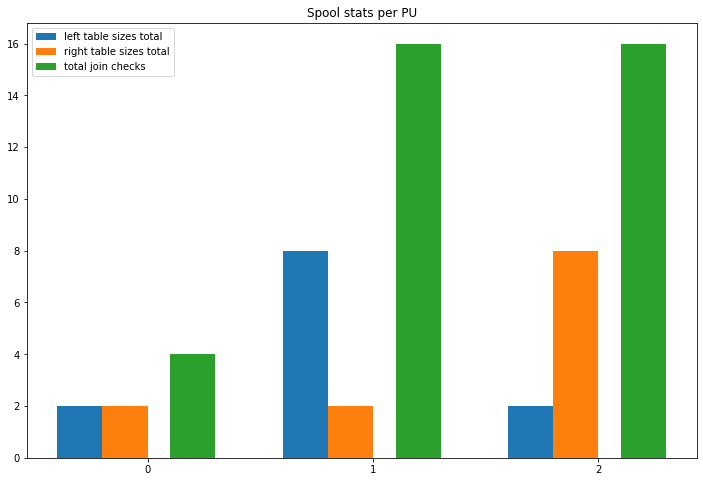

In [278]:
redis_stats.show()

In [271]:
dup_join_result, dup_join_stats = prpd.join_duplicate('R', 'a', 'S', 'b')

Total move operations - 24


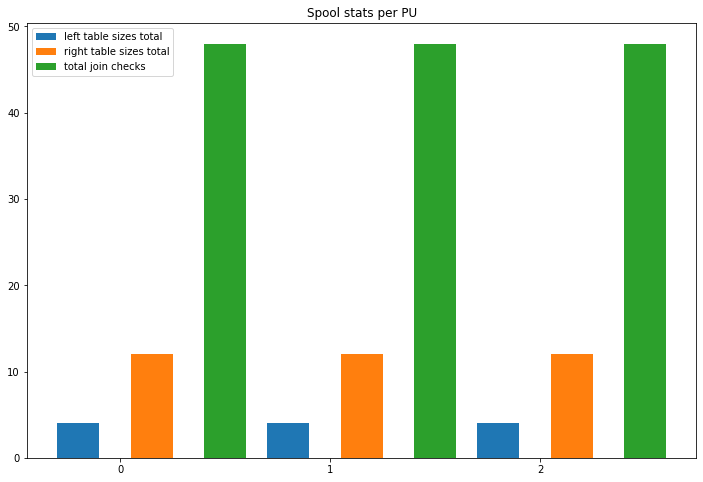

In [272]:
dup_join_stats.show()

In [210]:
print(redis_join_result)
print(dup_join_result)

Table(join_result, ['x', 'a', 'y', 'b'])
	{'x': 7, 'a': 3, 'y': 8, 'b': 3}
	{'x': 5, 'a': 6, 'y': 11, 'b': 6}
	{'x': 3, 'a': 1, 'y': 0, 'b': 1}
	{'x': 3, 'a': 1, 'y': 1, 'b': 1}
	{'x': 12, 'a': 1, 'y': 0, 'b': 1}
	{'x': 12, 'a': 1, 'y': 1, 'b': 1}
	{'x': 4, 'a': 1, 'y': 0, 'b': 1}
	{'x': 4, 'a': 1, 'y': 1, 'b': 1}
	{'x': 7, 'a': 1, 'y': 0, 'b': 1}
	{'x': 7, 'a': 1, 'y': 1, 'b': 1}
	{'x': 5, 'a': 1, 'y': 0, 'b': 1}
	{'x': 5, 'a': 1, 'y': 1, 'b': 1}
	{'x': 8, 'a': 1, 'y': 0, 'b': 1}
	{'x': 8, 'a': 1, 'y': 1, 'b': 1}
	{'x': 6, 'a': 2, 'y': 3, 'b': 2}
	{'x': 6, 'a': 2, 'y': 6, 'b': 2}
	{'x': 6, 'a': 2, 'y': 4, 'b': 2}
	{'x': 6, 'a': 2, 'y': 10, 'b': 2}
	{'x': 6, 'a': 2, 'y': 2, 'b': 2}
	{'x': 6, 'a': 2, 'y': 8, 'b': 2}
	{'x': 1, 'a': 2, 'y': 3, 'b': 2}
	{'x': 1, 'a': 2, 'y': 6, 'b': 2}
	{'x': 1, 'a': 2, 'y': 4, 'b': 2}
	{'x': 1, 'a': 2, 'y': 10, 'b': 2}
	{'x': 1, 'a': 2, 'y': 2, 'b': 2}
	{'x': 1, 'a': 2, 'y': 8, 'b': 2}
Table(join_result, ['x', 'a', 'y', 'b'])
	{'x': 3, 'a': 1, 'y': 0, 'b'

In [211]:
redis_join_result == dup_join_result

True

In [217]:
# hardcoding L1 and L2.
L1 = set([1])
L2 = set([2])
prpd_join_result, prpd_join_stats = prpd.join_prpd('R', 'a', 'S', 'b', L1, L2)

In [219]:
# verify result correctness
redis_join_result == prpd_join_result

True

Total move operations - 16


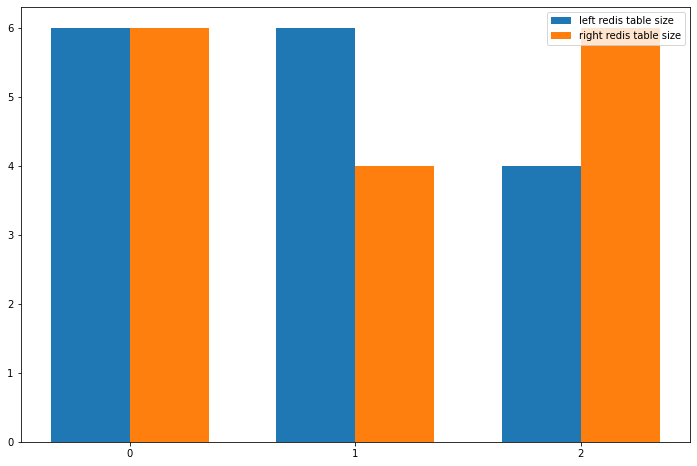

In [220]:
prpd_join_stats.show()